# Predict customer churn

## 1.0 Problem and purpose

Why do customers leave a business and how can a business prevent losing customers? 

Customer churn or attrition is when a customer stops doing busienss with a company. It is a considerable problem especially in subscription-dependent industries such as telecommunications. Customer churn directly affects revenue. It could also increase costs because it is more expensive to acquire new customers than to keep existing customers. 

The purpose of this case study is to help a telecommunications company determine key drivers of customer churn and to predict the chances of a customer leaving so that appropriate actions can be taken to prevent it. 

## 2.0 Dataset(s)

The dataset contains customer records of a wireless, internet, TV, homephone, and home monitoring services. The dataset is comprised of:
* 7043 records
* 21 features including 12 string, 5 boolean, 2 integer features
* the binary label called "Churn" which indicates whether a customer left within the last month
* demographic variables such as gender, age range, and if they have partners and dependents

## 3.0 Challenges and approach

Timeliness is important. We are going to take a fast and simple approach, then consider possible evolution of the model after this proof-of-concept (POC). We will use logistic regression to determine the probability of customers leaving. We can then leverage the relationship of the probability of churn and other features to determine key drivers of churn.

For problems such as churn prediction, we want to optimise certain metrics. For instance, false negative and fase positive predictions could prove costly and thus would require special attention. ROC AUC can gives insight into the relationship of the true positive rate and false positive rate. We will use this to evaluate the model.

## 4.0 Implementation

In [1]:
# Set-up libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Check source
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
# Load data
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Check for missing values
df.duplicated().sum()

0

In [5]:
# Check for missing values
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

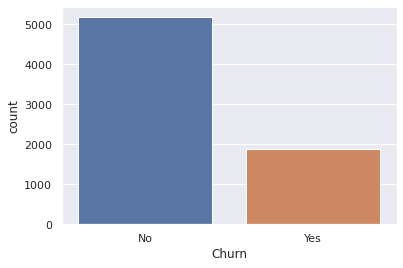

In [6]:
# Explore label breakdown
df['Churn'].value_counts()
sns.countplot(df['Churn'])

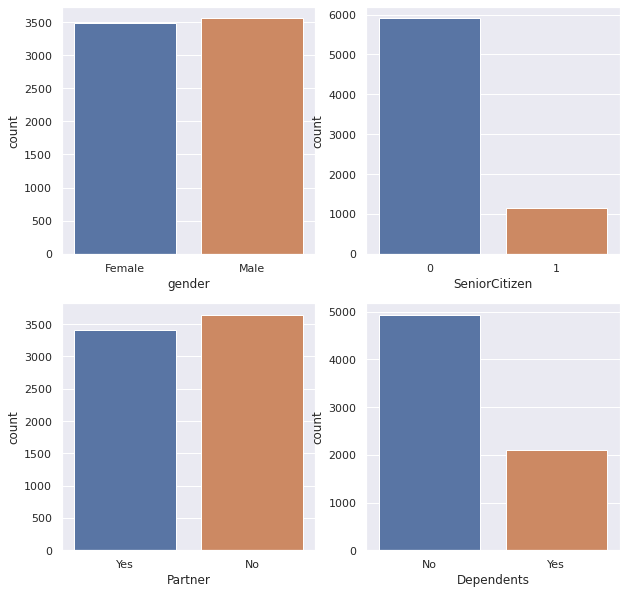

In [7]:
# Explore demographic features quickly
f, ax = plt.subplots(2,2, figsize=(10,10))

sns.countplot(df['gender'], ax=ax[0,0])
sns.countplot(df['SeniorCitizen'], ax=ax[0,1])
sns.countplot(df['Partner'], ax=ax[1,0])
sns.countplot(df['Dependents'], ax=ax[1,1])

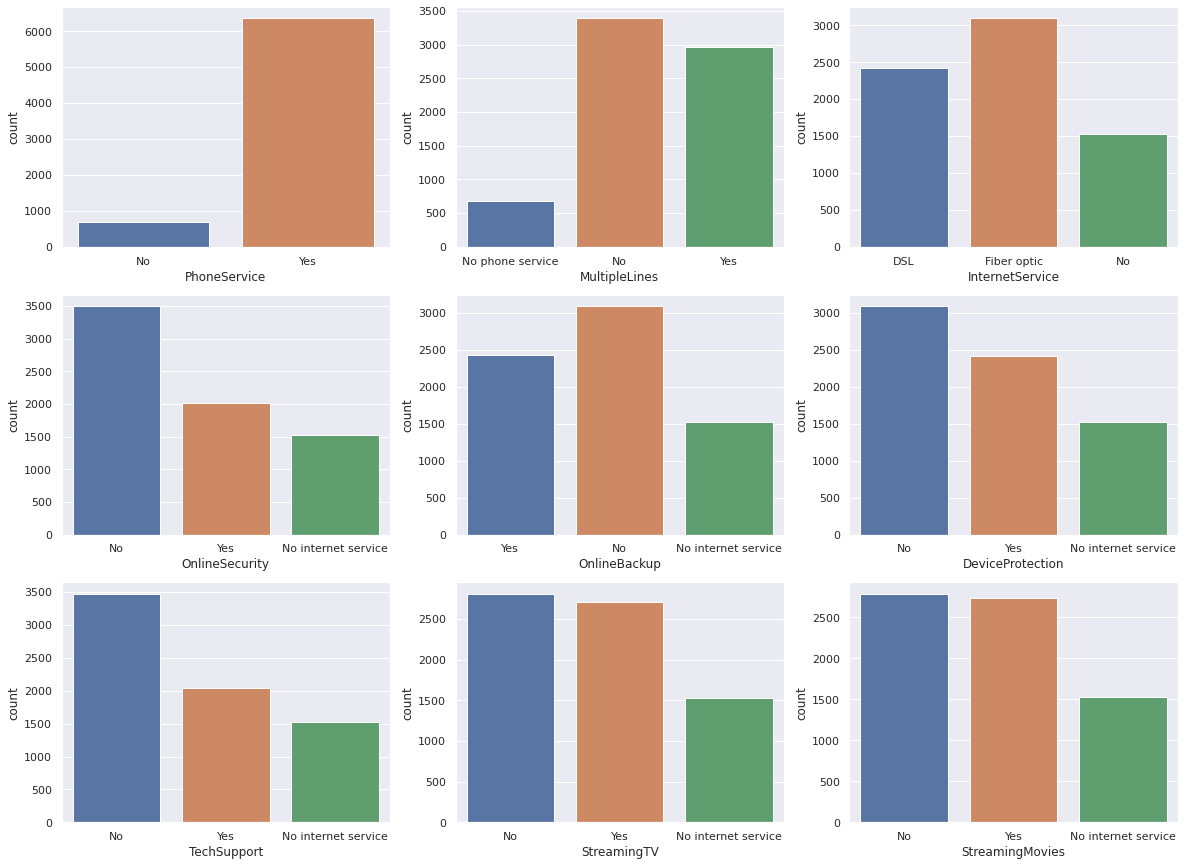

In [8]:
# Explore services subscribed to quickly
f, ax = plt.subplots(3,3, figsize=(20,15))

sns.countplot(df['PhoneService'], ax=ax[0,0])
sns.countplot(df['MultipleLines'], ax=ax[0,1])
sns.countplot(df['InternetService'], ax=ax[0,2])
sns.countplot(df['OnlineSecurity'], ax=ax[1,0])
sns.countplot(df['OnlineBackup'], ax=ax[1,1])
sns.countplot(df['DeviceProtection'], ax=ax[1,2])
sns.countplot(df['TechSupport'], ax=ax[2,0])
sns.countplot(df['StreamingTV'], ax=ax[2,1])
sns.countplot(df['StreamingMovies'], ax=ax[2,2])

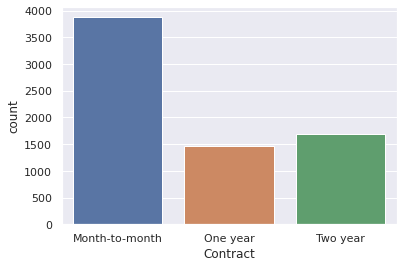

In [9]:
# Explore accounts quickly
df['Contract'].value_counts()
sns.countplot(df['Contract'])

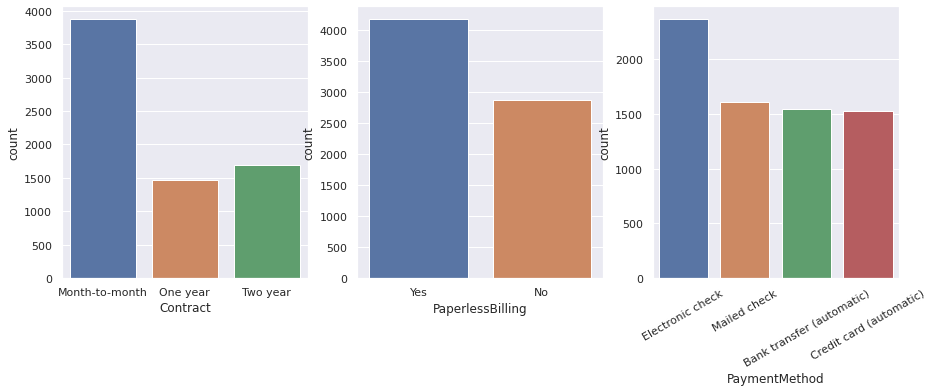

In [10]:
# Explore accounts quickly
f, ax = plt.subplots(1,3, figsize=(15,5))
plt.xticks(rotation=30)

sns.countplot(df['Contract'], ax=ax[0])
sns.countplot(df['PaperlessBilling'], ax=ax[1])
sns.countplot(df['PaymentMethod'], ax=ax[2])

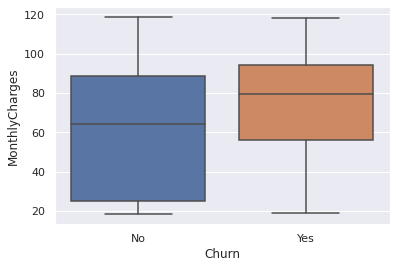

In [11]:
# Explore monthly payments against churns
sns.boxplot('Churn', 'MonthlyCharges', data=df)

In [12]:
# Summarise
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [13]:
# Remove unuseable features
df.drop(['customerID'], axis=1, inplace=True)

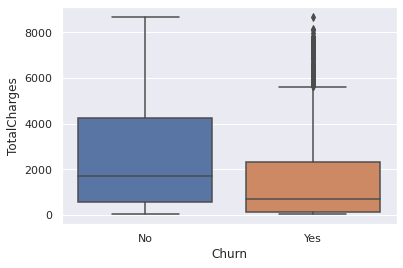

In [14]:
# Convert amounts of type string to numeric
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df.isna().sum()
df.dropna(inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Explore total charges against churns
sns.boxplot('Churn', 'TotalCharges', data=df)

A closer look at the "Total Charges" feature shows empty spaces for missing values. There are 11 records in total that does this. Above, we drop the 11 records.This is not the onl way to handle missing values (see [types of missing data](https://github.com/jamiemorales/project-data-scientist/blob/master/data-preprocessing.pdf)). In this case though, we have over 7k observations and 11 records with missing data. For now, we apply a listwise deletion or complete-case analysis which removes all the data for an observation that has one or more missing values.

The data type for this column is also of type String. Since this pertains to amounts, we converted it to numeric above.

In [15]:
# Convert labels from Yes/No to 1/0 for Churn
df['Churn'].replace('Yes', 1, inplace=True)
df['Churn'].replace('No', 0, inplace=True)

# Convert labels from 1/0 to Yes/No for SeniorCitizen
df['SeniorCitizen'].replace(1, 'Yes', inplace=True)
df['SeniorCitizen'].replace(0, 'No', inplace=True)

# Encode other variables
df_onehot = pd.get_dummies(df)

df_onehot.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


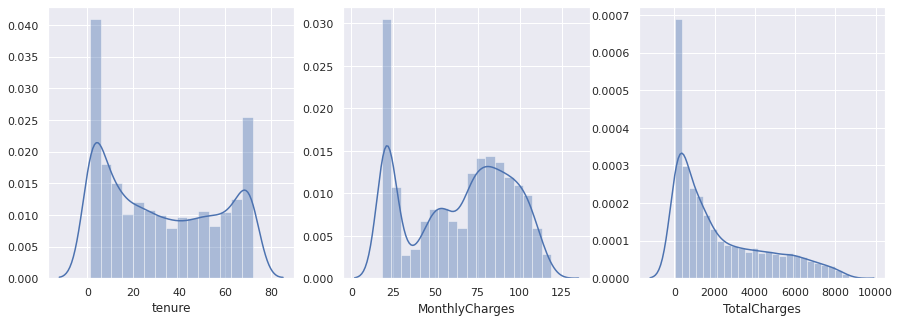

In [16]:
# Visualise distribution before
f, ax = plt.subplots(1,3, figsize=(15,5))

sns.distplot(df_onehot['tenure'], ax=ax[0])
sns.distplot(df_onehot['MonthlyCharges'], ax=ax[1])
sns.distplot(df_onehot['TotalCharges'], ax=ax[2])

In [17]:
# Scale
scaler = MinMaxScaler()
df_onehot['tenure'] = scaler.fit_transform(df_onehot['tenure'].values.reshape(-1, 1))
df_onehot['MonthlyCharges'] = scaler.fit_transform(df_onehot['MonthlyCharges'].values.reshape(-1, 1))
df_onehot['TotalCharges'] = scaler.fit_transform(df_onehot['TotalCharges'].values.reshape(-1, 1))

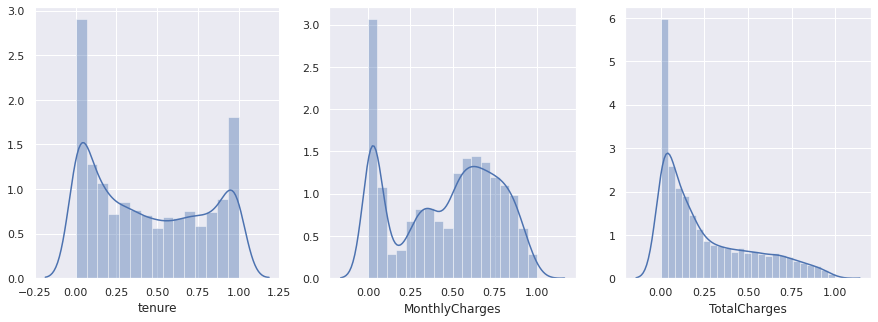

In [18]:
# Visualise distribution after
f, ax = plt.subplots(1,3, figsize=(15,5))

sns.distplot(df_onehot['tenure'], ax=ax[0])
sns.distplot(df_onehot['MonthlyCharges'], ax=ax[1])
sns.distplot(df_onehot['TotalCharges'], ax=ax[2])

In [19]:
# Split dataset
X = df_onehot.drop(['Churn'], axis=1)
y = df_onehot['Churn'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


      Actual  Prediction
717        1           0
639        0           0
72         0           0
1089       0           0
943        1           1
1075       0           1
983        1           1
824        0           0
720        0           0
22         0           0
26         0           0
1072       1           0
ROC AUC: 71.64 %


Text(0, 0.5, 'True Positive Rate')

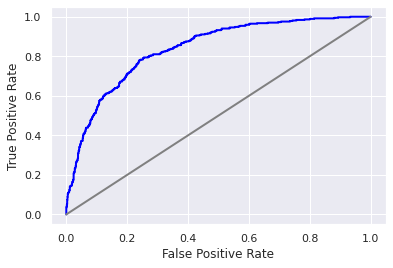

In [20]:
# Build and train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Apply model
y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual': y_test.flatten(),
                                 'Prediction': y_predict.flatten()})
print(actual_vs_predict.sample(12))

# Evaluate model
print('ROC AUC: %.2f' % (roc_auc_score(y_test,y_predict)*100), '%')

# Visualise ROC
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw=2, color='blue')
plt.plot([0,1], [0,1], lw=2, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

AxesSubplot(0.125,0.125;0.775x0.755)


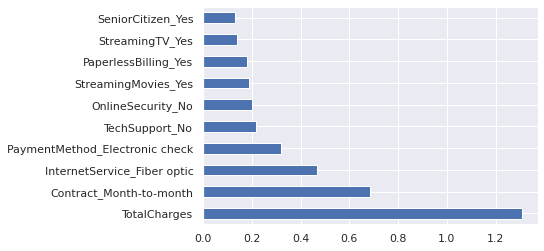

In [21]:
# Top ten features with positive relationship to churn
weights = pd.Series(model.coef_[0], index=X.columns.values)
print(weights.sort_values(ascending=False)[:10].plot(kind='barh'))

The positive relationship of the 10 features above to customer churn indicates that the likelihood of customer attrition increases with the values of these features.

AxesSubplot(0.125,0.125;0.775x0.755)


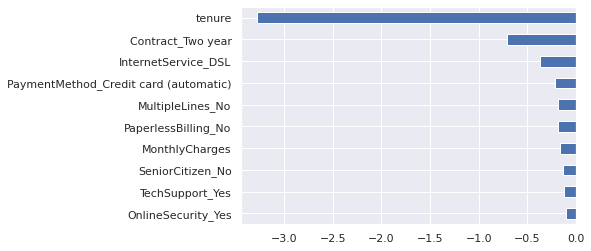

In [22]:
# Top ten features with negative relationship to churn
weights = pd.Series(model.coef_[0], index=X.columns.values)
print(weights.sort_values(ascending=False)[-10:].plot(kind='barh'))

The negative relationship of the 10 features above to customer churn indicates that the likelihood of customer attrition decreases with the values of these features.

## 5.0 Results discussion

Key drivers of churn

We were able to predict the probability of a customer leaving in the next month or so with ROC AUC of 71% leveraging the 7k+ customer records on hand. Our model did better than a random guess of 50-50. This means that we can identify customers who are about to leave, at a relatively accurate rate, for intervention. 

We found out that there is a positive relationship of the 10 features below to customer churn. This indicates that the likelihood of customer churn increases with the values of these features. In other words, customers who tend to leave also tend to:

1. Have high total charges
2. Have a month to month contract
3. Subscribed to a fiber optic type of internet service
4. Pay with electronic checque
5. Not have techsupport subscription
6. Not have online security subscription
7. Have streaming movies subscription
8. Have paperless billing 
9. Have streaming tv subscription
10. Are senior citizens

We also found out that there is a negative relationship of the 10 features below to customer churn. This indicates that the likelihood of customer churn decreases with the values of these features. In other words, customers who tend not to leave also tend to:

1. Have been with the company for a long time
2. Have two-year contracts
3. Subscribed to a DSL type of internet service
4. Pay with automated credit card payments
5. Not have multiple phone lines
6. Not have paperless billing
7. Lower monthly charges
8. Are non-senior citizens
9. Have techsupport subscription
10. Have online security subscription


## 6.0 Conclusion

Case study summary

In this case study, we are took a fast and simple approach and used logistic regression to determine the probability of customers leaving. We then leveraged the relationship of the probability of churn to that of the features to determine possible drivers of churn. Moreover, ROC AUC was used to evaluate the model because it provides insight into the relationship of the true positive rate and the false positive rate, certain areas of concern for our problem and purposes.

Future directions

It would be insightful to develop a comprehensive view of the customer and then link that to the model. This includes the current state view of the customer across domains such as social media and other platforms. This also includes the customer journey as far back as the acquisition or onboarding stage to upgrade cycles and so on. Moreover, usage of the products and touchpoints such as customer service calls. 

Additionally, it would be interesting to associate customer lifetime value to the customer churn model. The comparison of widely used algorithms such as decision tree classifiers and ensemble methods is another curious avenue.

Real-world retrospective

Loss is unavoidable in business but it can be mitigated. Finding the key drivers and taking preventative actions can help bring down the loss to an acceptable level. Timeliness of the results and comprehensive views of the client are both important. To satisfy both, we can rapidly deploy a lite model and then evolve it over time.